C:\Users\dodam\AppData\Local\Temp\ipykernel_23268\491790529.py:27: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  grid_in_sejong = grid[grid.intersects(sejong.unary_union)]


<Axes: >

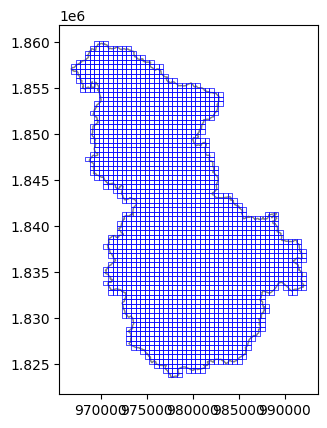

In [2]:
import geopandas as gpd
from shapely.geometry import box

# 세종시 shp 불러오기
sejong = gpd.read_file("LARD_ADM_SECT_SGG_세종/LARD_ADM_SECT_SGG_36_202504.shp", encoding="cp949").to_crs("EPSG:5179")

# 세종시 전체 경계 추출
minx, miny, maxx, maxy = sejong.total_bounds

# 격자 크기 (500m)
grid_size = 500
grid_cells = []

x = minx
while x < maxx:
    y = miny
    while y < maxy:
        cell = box(x, y, x + grid_size, y + grid_size)
        grid_cells.append(cell)
        y += grid_size
    x += grid_size

# GeoDataFrame으로 변환
grid = gpd.GeoDataFrame(geometry=grid_cells, crs="EPSG:5179")

# 세종시 내부에 있는 격자만 필터링
grid_in_sejong = grid[grid.intersects(sejong.unary_union)]

# 시각화
ax = sejong.plot(edgecolor='gray', facecolor='none')
grid_in_sejong.plot(ax=ax, edgecolor='blue', facecolor='none', linewidth=0.5)

In [3]:
grid_in_sejong["centroid"] = grid_in_sejong.geometry.centroid
centroids = grid_in_sejong.set_geometry("centroid")

# 중심점을 geometry로 설정 (Polygon → Point)
centroids = grid_in_sejong.copy()
centroids["geometry"] = centroids.geometry.centroid
# 이제 centroids.geometry는 Point가 됩니다.

c:\Workspace\gongmojeon1\venv\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [3]:
CATEGORY_GROUP_CODES = {
    '음식점': 'FD6',
    '카페': 'CE7',
    '학원': 'AC5',
    '병원': 'HP8',
    '편의점': 'CS2',
    '약국': 'PM9',
    '중개업소': 'AG2',
    '주차장': 'PK6',
    '은행': 'BK9',
    '학교': 'SC4',
    '숙박': 'AD5',
    '관광명소': 'AT4',
    '대형마트': 'MT1',
    '공공기관': 'PO3',
    '주유소,충전소': 'OL7',
    '어린이집,유치원': 'PS3',
    '문화시설': 'CT1'
}

In [4]:
import os
from dotenv import load_dotenv

# .env 불러오기
load_dotenv()
KAKAO_API_KEY = os.getenv("KAKAO_API_KEY")
HEADERS = {"Authorization": f"KakaoAK {KAKAO_API_KEY}"}

In [4]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point

# 1. POI 데이터 불러오기 및 좌표계 변환
poi_df = pd.read_csv("sejong_poi_recovered.csv")
poi_gdf = gpd.GeoDataFrame(
    poi_df,
    geometry=gpd.points_from_xy(poi_df["x"], poi_df["y"]),
    crs="EPSG:4326"
).to_crs("EPSG:5179")

# 2. 중심점 좌표 리스트 생성
centroid_coords = centroids["geometry"].apply(lambda geom: (geom.x, geom.y)).tolist()

# 3. POI 좌표 리스트 생성
poi_coords = poi_gdf["geometry"].apply(lambda geom: (geom.x, geom.y)).tolist()

# 4. 반경 750m 내에 포함된 중심점 계산
covered_centroids = set()
for i, (cx, cy) in enumerate(centroid_coords):
    for px, py in poi_coords:
        dist = np.sqrt((px - cx)**2 + (py - cy)**2)
        if dist <= 750:
            covered_centroids.add(i)
            break

# 5. 수집률 계산
total = len(centroid_coords)
covered = len(covered_centroids)
coverage_ratio = round(covered / total * 100, 2)

print(f"총 중심점 수: {total}")
print(f"수집된 중심점 수: {covered}")
print(f"수집률: {coverage_ratio}%")

총 중심점 수: 2024
수집된 중심점 수: 1107
수집률: 54.69%


In [7]:
import pandas as pd
import asyncio
import aiohttp
from aiolimiter import AsyncLimiter
from shapely.ops import transform
import pyproj
import os
import nest_asyncio
from tqdm import tqdm
from dotenv import load_dotenv

nest_asyncio.apply()
load_dotenv()

# 카카오 API 키 불러오기
KAKAO_API_KEY = os.getenv("KAKAO_API_KEY")
HEADERS = {"Authorization": f"KakaoAK {KAKAO_API_KEY}"}

# 카테고리 설정
CATEGORY_GROUP_CODES = {
    '음식점': 'FD6',
    '카페': 'CE7',
    '편의점': 'CS2'
}

# 좌표 변환 (EPSG:5179 → EPSG:4326)
project = pyproj.Transformer.from_crs("EPSG:5179", "EPSG:4326", always_xy=True).transform
centroids["wgs84"] = centroids.geometry.apply(lambda geom: transform(project, geom))

# 기존 수집 데이터 불러오기
if os.path.exists("sejong_poi_recovered.csv"):
    df_all = pd.read_csv("sejong_poi_recovered.csv")
    collected_idxs = set(df_all["grid_idx"].unique())
    all_pois = df_all.to_dict(orient="records")
else:
    collected_idxs = set()
    all_pois = []

# 요청 제한
limiter = AsyncLimiter(max_rate=20, time_period=1)
failed_tasks = []

# 비동기 API 호출 함수
async def fetch_poi(session, x, y, idx, group_name, group_code, retry=0, max_retries=2):
    all_docs = []
    for page in range(1, 45):
        params = {
            "category_group_code": group_code,
            "x": x,
            "y": y,
            "radius": 750,
            "page": page,
            "size": 15
        }
        url = "https://dapi.kakao.com/v2/local/search/category.json"
        async with limiter:
            try:
                async with session.get(url, headers=HEADERS, params=params, timeout=10) as response:
                    if response.status != 200:
                        print(f"❌ Error {response.status} at idx={idx}, group={group_name}")
                        failed_tasks.append((idx, group_name))
                        break
                    data = await response.json()
                    documents = data.get("documents", [])
                    if not documents:
                        break
                    for doc in documents:
                        doc["grid_idx"] = idx
                        doc["group_name"] = group_name
                        all_docs.append(doc)
            except Exception as e:
                print(f"⚠️ Exception at idx={idx}, group={group_name}: {e}")
                if retry < max_retries:
                    await asyncio.sleep(1)
                    return await fetch_poi(session, x, y, idx, group_name, group_code, retry + 1)
                failed_tasks.append((idx, group_name))
                break
        await asyncio.sleep(0.5)
    return all_docs

# 저장 함수
def save_data():
    global all_pois, collected_idxs
    df_temp = pd.DataFrame(all_pois)
    df_temp = df_temp.drop_duplicates(subset=["id", "group_name"])
    df_temp = df_temp[df_temp["address_name"].str.contains("세종특별자치시", na=False)]
    df_temp.to_csv("sejong_poi_recovered.csv", index=False)
    collected_idxs = set(df_temp["grid_idx"].unique())
    print(f"💾 저장 완료 - 현재 수집량: {len(df_temp)}")

# 메인 수집 함수
async def main():
    tasks = []
    async with aiohttp.ClientSession() as session:
        # ✅ 변경된 부분 시작
        target_centroids = centroids[~centroids.index.isin(collected_idxs)]
        for idx, row in tqdm(target_centroids.iterrows(), total=len(target_centroids)):
        # ✅ 변경된 부분 끝
            x, y = row["wgs84"].x, row["wgs84"].y
            for group_name, group_code in CATEGORY_GROUP_CODES.items():
                tasks.append(fetch_poi(session, x, y, idx, group_name, group_code))

            if len(tasks) >= 20 * len(CATEGORY_GROUP_CODES):
                results = await asyncio.gather(*tasks)
                for poi_list in results:
                    all_pois.extend(poi_list)
                tasks.clear()
                save_data()

        if tasks:
            results = await asyncio.gather(*tasks)
            for poi_list in results:
                all_pois.extend(poi_list)
            save_data()

# 실패 재시도 함수
async def retry_failed_tasks():
    if not failed_tasks:
        return
    print(f"🔁 재시도 시작 - 실패한 요청 수: {len(failed_tasks)}")
    retry_results = []
    async with aiohttp.ClientSession() as session:
        for idx, group_name in failed_tasks:
            row = centroids.iloc[idx]
            x, y = row["wgs84"].x, row["wgs84"].y
            group_code = CATEGORY_GROUP_CODES[group_name]
            retry_results.append(fetch_poi(session, x, y, idx, group_name, group_code))
        results = await asyncio.gather(*retry_results)
        for poi_list in results:
            all_pois.extend(poi_list)
        save_data()
    print("✅ 재시도 완료")

# 실행
if __name__ == "__main__":
    asyncio.run(main())
    asyncio.run(retry_failed_tasks())

  1%|          | 20/1673 [00:26<36:54,  1.34s/it]

💾 저장 완료 - 현재 수집량: 2568


  2%|▏         | 40/1673 [00:54<37:30,  1.38s/it]

💾 저장 완료 - 현재 수집량: 2576


  4%|▎         | 60/1673 [01:22<37:18,  1.39s/it]

💾 저장 완료 - 현재 수집량: 2576


  5%|▍         | 80/1673 [01:51<37:30,  1.41s/it]

💾 저장 완료 - 현재 수집량: 2602


  6%|▌         | 100/1673 [02:19<36:37,  1.40s/it]

💾 저장 완료 - 현재 수집량: 2603


  7%|▋         | 120/1673 [02:57<40:42,  1.57s/it]

💾 저장 완료 - 현재 수집량: 2605


  8%|▊         | 140/1673 [03:24<38:18,  1.50s/it]

💾 저장 완료 - 현재 수집량: 2609


 10%|▉         | 160/1673 [03:51<36:32,  1.45s/it]

💾 저장 완료 - 현재 수집량: 2611


 11%|█         | 180/1673 [04:18<35:17,  1.42s/it]

💾 저장 완료 - 현재 수집량: 2613


 12%|█▏        | 200/1673 [04:45<34:26,  1.40s/it]

💾 저장 완료 - 현재 수집량: 2614


 13%|█▎        | 220/1673 [05:17<35:10,  1.45s/it]

💾 저장 완료 - 현재 수집량: 2618


 14%|█▍        | 240/1673 [05:44<33:59,  1.42s/it]

💾 저장 완료 - 현재 수집량: 2619


 16%|█▌        | 260/1673 [06:11<33:15,  1.41s/it]

💾 저장 완료 - 현재 수집량: 2619


 17%|█▋        | 280/1673 [06:40<33:03,  1.42s/it]

💾 저장 완료 - 현재 수집량: 2629


 18%|█▊        | 300/1673 [07:08<32:12,  1.41s/it]

💾 저장 완료 - 현재 수집량: 2629


 19%|█▉        | 320/1673 [07:35<31:27,  1.39s/it]

💾 저장 완료 - 현재 수집량: 2632


 20%|██        | 340/1673 [08:03<31:02,  1.40s/it]

💾 저장 완료 - 현재 수집량: 2633


 22%|██▏       | 360/1673 [08:44<34:40,  1.58s/it]

💾 저장 완료 - 현재 수집량: 2663


 23%|██▎       | 380/1673 [09:36<40:52,  1.90s/it]

💾 저장 완료 - 현재 수집량: 2734


 24%|██▍       | 400/1673 [10:03<36:46,  1.73s/it]

💾 저장 완료 - 현재 수집량: 2736


 25%|██▌       | 420/1673 [11:25<51:07,  2.45s/it]

💾 저장 완료 - 현재 수집량: 2818


 26%|██▋       | 440/1673 [11:53<43:37,  2.12s/it]

💾 저장 완료 - 현재 수집량: 2828


 27%|██▋       | 460/1673 [12:31<41:32,  2.05s/it]

💾 저장 완료 - 현재 수집량: 2832


 29%|██▊       | 480/1673 [13:20<43:11,  2.17s/it]

💾 저장 완료 - 현재 수집량: 2847


 30%|██▉       | 500/1673 [13:46<37:32,  1.92s/it]

💾 저장 완료 - 현재 수집량: 2847


 31%|███       | 520/1673 [14:28<37:44,  1.96s/it]

💾 저장 완료 - 현재 수집량: 2847


 32%|███▏      | 540/1673 [14:54<33:31,  1.78s/it]

💾 저장 완료 - 현재 수집량: 2856


 33%|███▎      | 560/1673 [15:21<30:29,  1.64s/it]

💾 저장 완료 - 현재 수집량: 2859


 35%|███▍      | 580/1673 [16:08<33:43,  1.85s/it]

💾 저장 완료 - 현재 수집량: 2937


 36%|███▌      | 600/1673 [16:35<30:24,  1.70s/it]

💾 저장 완료 - 현재 수집량: 2955


 37%|███▋      | 620/1673 [17:02<27:59,  1.60s/it]

💾 저장 완료 - 현재 수집량: 2960


 38%|███▊      | 640/1673 [17:46<30:47,  1.79s/it]

💾 저장 완료 - 현재 수집량: 2967


 39%|███▉      | 660/1673 [18:14<28:07,  1.67s/it]

💾 저장 완료 - 현재 수집량: 2968


 41%|████      | 680/1673 [19:02<31:07,  1.88s/it]

💾 저장 완료 - 현재 수집량: 2986


 42%|████▏     | 700/1673 [19:31<28:22,  1.75s/it]

💾 저장 완료 - 현재 수집량: 2993


 43%|████▎     | 720/1673 [19:58<25:54,  1.63s/it]

💾 저장 완료 - 현재 수집량: 2993


 44%|████▍     | 740/1673 [20:48<29:35,  1.90s/it]

💾 저장 완료 - 현재 수집량: 3025


 45%|████▌     | 760/1673 [21:15<26:21,  1.73s/it]

💾 저장 완료 - 현재 수집량: 3026


 47%|████▋     | 780/1673 [21:49<25:43,  1.73s/it]

💾 저장 완료 - 현재 수집량: 3049


 48%|████▊     | 800/1673 [22:16<23:26,  1.61s/it]

💾 저장 완료 - 현재 수집량: 3053


 49%|████▉     | 820/1673 [22:44<21:53,  1.54s/it]

💾 저장 완료 - 현재 수집량: 3122


 50%|█████     | 840/1673 [23:17<21:54,  1.58s/it]

💾 저장 완료 - 현재 수집량: 3134


 51%|█████▏    | 860/1673 [24:13<26:19,  1.94s/it]

💾 저장 완료 - 현재 수집량: 3160


 53%|█████▎    | 880/1673 [24:47<24:46,  1.87s/it]

💾 저장 완료 - 현재 수집량: 3177


 54%|█████▍    | 900/1673 [25:46<28:12,  2.19s/it]

💾 저장 완료 - 현재 수집량: 3199


 55%|█████▍    | 920/1673 [26:12<24:17,  1.94s/it]

💾 저장 완료 - 현재 수집량: 3207


 56%|█████▌    | 940/1673 [27:28<30:24,  2.49s/it]

💾 저장 완료 - 현재 수집량: 3337


 57%|█████▋    | 960/1673 [28:15<29:04,  2.45s/it]

💾 저장 완료 - 현재 수집량: 3349


 59%|█████▊    | 980/1673 [29:31<32:55,  2.85s/it]

💾 저장 완료 - 현재 수집량: 3464


 60%|█████▉    | 1000/1673 [31:21<40:55,  3.65s/it]

💾 저장 완료 - 현재 수집량: 3777


 61%|██████    | 1020/1673 [32:34<39:44,  3.65s/it]

💾 저장 완료 - 현재 수집량: 3782


 62%|██████▏   | 1040/1673 [33:44<42:47,  4.06s/it]

💾 저장 완료 - 현재 수집량: 3995


 63%|██████▎   | 1060/1673 [35:50<53:12,  5.21s/it]

💾 저장 완료 - 현재 수집량: 4156


 65%|██████▍   | 1080/1673 [36:29<37:47,  3.82s/it]

💾 저장 완료 - 현재 수집량: 4156


 66%|██████▌   | 1100/1673 [37:30<33:42,  3.53s/it]

💾 저장 완료 - 현재 수집량: 4268


 67%|██████▋   | 1120/1673 [39:26<39:50,  4.32s/it]

💾 저장 완료 - 현재 수집량: 4388


 68%|██████▊   | 1140/1673 [40:05<31:26,  3.54s/it]

💾 저장 완료 - 현재 수집량: 4418


 69%|██████▉   | 1160/1673 [40:45<26:01,  3.04s/it]

💾 저장 완료 - 현재 수집량: 4493


 71%|███████   | 1180/1673 [42:01<26:54,  3.27s/it]

💾 저장 완료 - 현재 수집량: 4574


 72%|███████▏  | 1200/1673 [43:04<25:34,  3.24s/it]

💾 저장 완료 - 현재 수집량: 4635


 73%|███████▎  | 1220/1673 [43:33<20:21,  2.70s/it]

💾 저장 완료 - 현재 수집량: 4677


 74%|███████▍  | 1240/1673 [44:26<19:17,  2.67s/it]

💾 저장 완료 - 현재 수집량: 4692


 75%|███████▌  | 1260/1673 [45:10<17:26,  2.53s/it]

💾 저장 완료 - 현재 수집량: 4714


 77%|███████▋  | 1280/1673 [45:41<14:36,  2.23s/it]

💾 저장 완료 - 현재 수집량: 4715


 78%|███████▊  | 1300/1673 [46:38<15:01,  2.42s/it]

💾 저장 완료 - 현재 수집량: 4729


 79%|███████▉  | 1320/1673 [47:22<13:51,  2.36s/it]

💾 저장 완료 - 현재 수집량: 4760


 80%|████████  | 1340/1673 [48:29<14:43,  2.65s/it]

💾 저장 완료 - 현재 수집량: 4772


 81%|████████▏ | 1360/1673 [49:33<14:41,  2.82s/it]

💾 저장 완료 - 현재 수집량: 4794


 82%|████████▏ | 1380/1673 [50:34<14:06,  2.89s/it]

💾 저장 완료 - 현재 수집량: 4799


 84%|████████▎ | 1400/1673 [51:29<12:57,  2.85s/it]

💾 저장 완료 - 현재 수집량: 4802


 85%|████████▍ | 1420/1673 [52:31<12:19,  2.92s/it]

💾 저장 완료 - 현재 수집량: 4806


 86%|████████▌ | 1440/1673 [53:30<11:23,  2.93s/it]

💾 저장 완료 - 현재 수집량: 4810


 87%|████████▋ | 1460/1673 [54:16<09:42,  2.74s/it]

💾 저장 완료 - 현재 수집량: 4813


 88%|████████▊ | 1480/1673 [55:00<08:19,  2.59s/it]

💾 저장 완료 - 현재 수집량: 4822


 90%|████████▉ | 1500/1673 [56:09<08:12,  2.85s/it]

💾 저장 완료 - 현재 수집량: 4842


 91%|█████████ | 1520/1673 [57:31<08:11,  3.21s/it]

💾 저장 완료 - 현재 수집량: 4859


 92%|█████████▏| 1540/1673 [58:35<07:07,  3.22s/it]

💾 저장 완료 - 현재 수집량: 4866


 93%|█████████▎| 1560/1673 [59:53<06:26,  3.42s/it]

💾 저장 완료 - 현재 수집량: 4949


 94%|█████████▍| 1580/1673 [1:01:15<05:36,  3.62s/it]

💾 저장 완료 - 현재 수집량: 4970


 96%|█████████▌| 1600/1673 [1:02:34<04:31,  3.72s/it]

💾 저장 완료 - 현재 수집량: 4991


 97%|█████████▋| 1620/1673 [1:03:06<02:43,  3.08s/it]

💾 저장 완료 - 현재 수집량: 4995


 98%|█████████▊| 1640/1673 [1:03:56<01:36,  2.91s/it]

💾 저장 완료 - 현재 수집량: 5001


100%|██████████| 1673/1673 [1:04:35<00:00,  2.32s/it]

💾 저장 완료 - 현재 수집량: 5001


💾 저장 완료 - 현재 수집량: 5001


C:\Users\dodam\AppData\Local\Temp\ipykernel_38788\143390102.py:50: UserWarning: Glyph 49464 (\N{HANGUL SYLLABLE SE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\dodam\AppData\Local\Temp\ipykernel_38788\143390102.py:50: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\dodam\AppData\Local\Temp\ipykernel_38788\143390102.py:50: UserWarning: Glyph 53945 (\N{HANGUL SYLLABLE TEUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\dodam\AppData\Local\Temp\ipykernel_38788\143390102.py:50: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\dodam\AppData\Local\Temp\ipykernel_38788\143390102.py:50: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\dodam\AppData\Local\Temp\ipykernel_38788\143390102.py:50: UserWarning: Glyph 52824 (\N{HANGUL SYLLABLE CI}) missing from fon

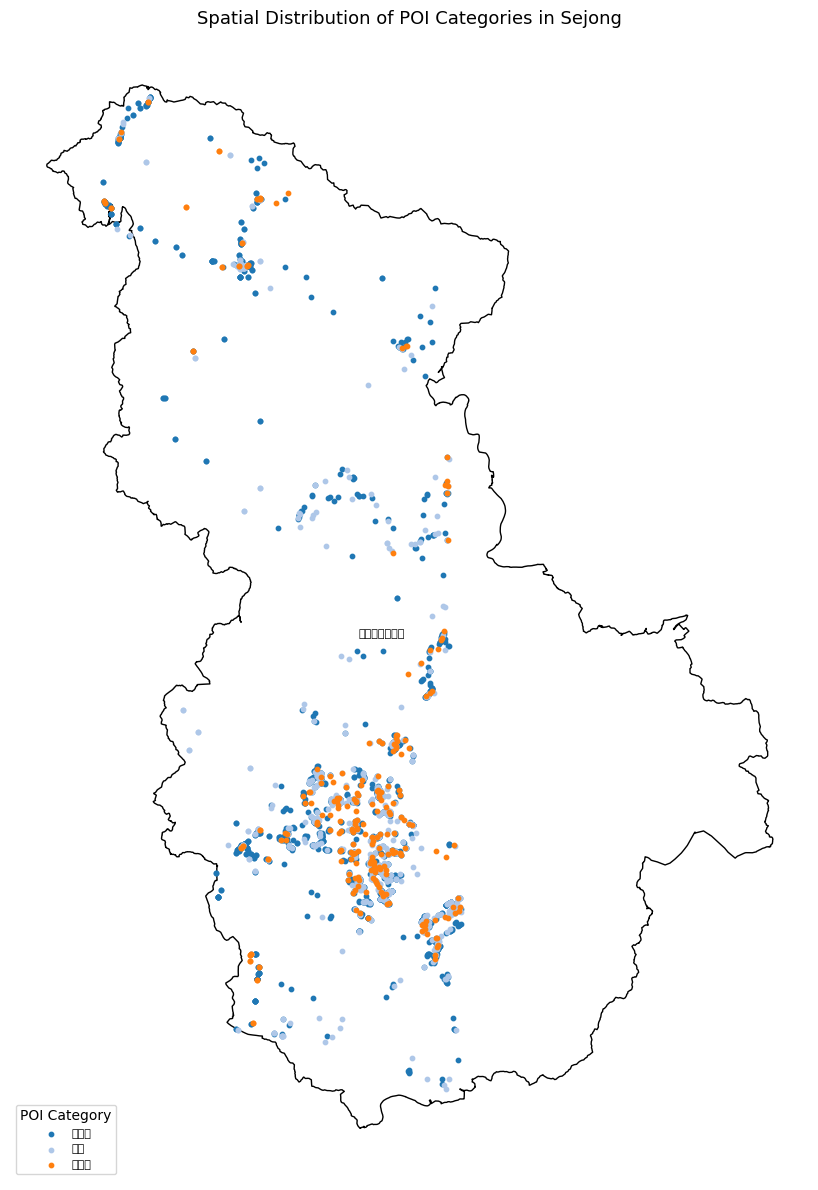

In [42]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# ① 전국 시군구 경계 불러오기
sgg_all = gpd.read_file("LARD_ADM_SECT_SGG_세종/LARD_ADM_SECT_SGG_36_202504.shp", encoding="cp949").to_crs("EPSG:5179")

# ② 세종시만 필터링 (정확한 컬럼명은 'SGG_NM')
sejong = sgg_all[sgg_all["SGG_NM"].str.contains("세종")]

# ③ POI 데이터 로딩 및 좌표 변환
df = pd.read_csv("sejong_poi_recovered.csv")
gdf_poi = gpd.GeoDataFrame(
    df,
    geometry=[Point(xy) for xy in zip(df["x"], df["y"])],
    crs="EPSG:4326"
).to_crs("EPSG:5179")

# ④ 시각화 시작
fig, ax = plt.subplots(figsize=(10, 12))

# 전국 배경지도 (연한 회색)
sgg_all.plot(ax=ax, facecolor='none', edgecolor='lightgray', linewidth=0.3)

# 세종시 경계 강조
sejong.plot(ax=ax, facecolor='white', edgecolor='black', linewidth=1)

# POI 카테고리별 시각화
categories = gdf_poi["group_name"].unique()
colors = plt.cm.tab20.colors

for i, cat in enumerate(categories):
    gdf_poi[gdf_poi["group_name"] == cat].plot(
        ax=ax,
        markersize=10,
        color=colors[i % len(colors)],
        label=cat
    )

# 세종시 이름 라벨링
for idx, row in sejong.iterrows():
    centroid = row.geometry.centroid
    plt.annotate(row["SGG_NM"], (centroid.x, centroid.y), fontsize=8, ha='center')

# 제목/범례/레이아웃 설정
plt.legend(title="POI Category", loc="lower left", fontsize=8)
plt.title("Spatial Distribution of POI Categories in Sejong", fontsize=13)
plt.axis("off")
plt.tight_layout()
plt.show()

In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# ① CSV 불러오기
df = pd.read_csv("sejong_poi_recovered.csv")

# ② 좌표 → geometry 변환 (WGS84 → EPSG:5179 필요)
gdf = gpd.GeoDataFrame(
    df,
    geometry=[Point(xy) for xy in zip(df["x"], df["y"])],
    crs="EPSG:4326"
).to_crs("EPSG:5179")  # 투영 좌표계로 변환

In [5]:
import numpy as np
import rasterio
from rasterio.transform import from_origin
from scipy.stats import gaussian_kde

# ① 좌표 추출
xys = np.vstack([gdf.geometry.x, gdf.geometry.y])
kde = gaussian_kde(xys, bw_method=1000 / np.std(xys, axis=1).mean())  # bandwidth=1000m

# ② 격자 설정 (25m 해상도)
minx, miny, maxx, maxy = gdf.total_bounds
pixel_size = 25
nx = int((maxx - minx) / pixel_size)
ny = int((maxy - miny) / pixel_size)
xi, yi = np.meshgrid(
    np.linspace(minx, maxx, nx),
    np.linspace(miny, maxy, ny)
)
coords = np.vstack([xi.ravel(), yi.ravel()])
zi = kde(coords).reshape(xi.shape)

In [34]:
transform = from_origin(minx, maxy, pixel_size, pixel_size)
with rasterio.open(
    "sejong_kde_1000m.tif", "w",
    driver="GTiff",
    height=zi.shape[0],
    width=zi.shape[1],
    count=1,
    dtype=zi.dtype,
    crs="EPSG:5179",
    transform=transform,
) as dst:
    dst.write(zi, 1)

c:\Workspace\gongmojeon1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49464 (\N{HANGUL SYLLABLE SE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Workspace\gongmojeon1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Workspace\gongmojeon1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Workspace\gongmojeon1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52964 (\N{HANGUL SYLLABLE KEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Workspace\gongmojeon1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45328 (\N{HANGUL SYLLABLE NEOL}) missing from font(s) DejaVu Sans.
  fig.c

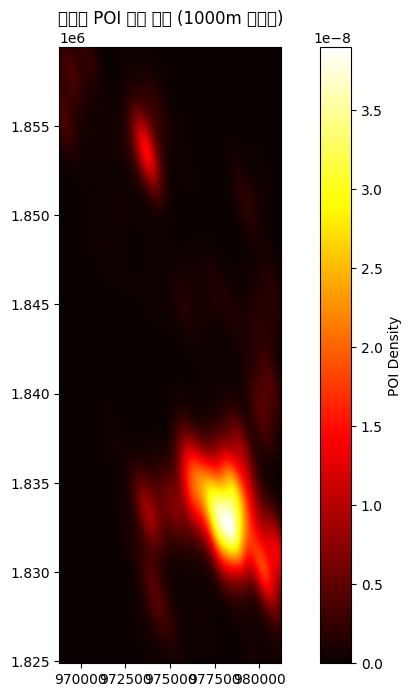

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(zi[::-1], cmap="hot", extent=(minx, maxx, miny, maxy))
plt.colorbar(label="POI Density")
plt.title("세종시 POI 커널 밀도 (1000m 대역폭)")
plt.show()


In [23]:
from skimage import measure
from shapely.geometry import Polygon
import geopandas as gpd
import numpy as np

# 1. KDE 다시 계산 (대역폭 줄이기)
from scipy.stats import gaussian_kde

xys = np.vstack([gdf.geometry.x, gdf.geometry.y])
kde = gaussian_kde(xys, bw_method=0.2)  # bandwidth 줄이기
zi = kde(np.vstack([xi.ravel(), yi.ravel()])).reshape(xi.shape)

# 2. 레벨 값 낮추기 (기존 50 → 5, 250 → 20)
levels = [1e-8, 2e-8]
pixel_size = 25  # KDE 셀 크기
minx, miny, maxx, maxy = gdf.total_bounds

# 3. 등치선 추출
level_polygons = {level: [] for level in levels}

for level in levels:
    contours = measure.find_contours(zi[::-1], level)  # Y축 반전

    for contour in contours:
        coords = np.fliplr(contour)
        coords[:, 0] = coords[:, 0] * pixel_size + minx
        coords[:, 1] = coords[:, 1] * pixel_size + miny
        poly = Polygon(coords)
        if poly.is_valid and poly.area > 0:
            level_polygons[level].append(poly)


In [24]:
gdf_level1 = gpd.GeoDataFrame(geometry=level_polygons[2e-8], crs="EPSG:5179")
gdf_level1["level"] = 1

gdf_level2 = gpd.GeoDataFrame(geometry=level_polygons[1e-8], crs="EPSG:5179")
gdf_level2["level"] = 2

gdf_center = pd.concat([gdf_level1, gdf_level2], ignore_index=True)
gdf_center.to_file("sejong_activity_centers_sample.geojson", driver="GeoJSON")


In [25]:
# 중심지별 POI 포함 여부 판단 (공간 조인)
joined = gpd.sjoin(gdf, gdf_center, how="inner", predicate="within")

# 중심지별 POI 수 집계
poi_counts = joined.groupby("index_right").size().rename("poi_count")

# 중심지 GeoDataFrame에 merge
gdf_center = gdf_center.join(poi_counts, how="left")
gdf_center["poi_count"] = gdf_center["poi_count"].fillna(0)

# 면적 계산 (EPSG:5179 기준 m² 단위)
gdf_center["area_m2"] = gdf_center.geometry.area

# 밀도 계산
gdf_center["poi_density"] = gdf_center["poi_count"] / (gdf_center["area_m2"] / 1e6)  # 단위: 개/km²

# 결과 저장
gdf_center.to_file("sejong_activity_centers_with_stats.geojson", driver="GeoJSON")


CRS: EPSG:5179


c:\Workspace\gongmojeon1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49464 (\N{HANGUL SYLLABLE SE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Workspace\gongmojeon1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Workspace\gongmojeon1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Workspace\gongmojeon1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54876 (\N{HANGUL SYLLABLE HWAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Workspace\gongmojeon1\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  fig.

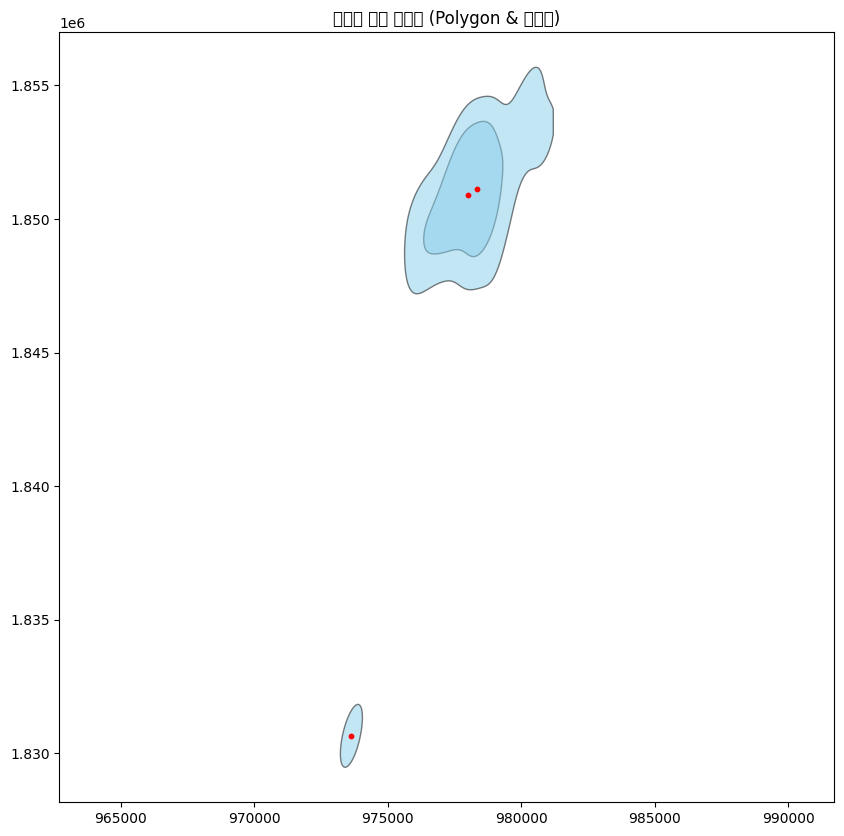

In [26]:
import geopandas as gpd
import matplotlib.pyplot as plt

# ① GeoJSON 불러오기
gdf_center = gpd.read_file("sejong_activity_centers_with_stats.geojson")

# ② 좌표계 확인 (EPSG:5179로 설정되어 있어야 함)
print("CRS:", gdf_center.crs)

# ③ 시각화
fig, ax = plt.subplots(figsize=(10, 10))
gdf_center.plot(ax=ax, edgecolor='black', facecolor='skyblue', alpha=0.5)

# 중심점 표시 (선택)
gdf_center["centroid"] = gdf_center.geometry.centroid
gdf_center.set_geometry("centroid").plot(ax=ax, color='red', markersize=10)

plt.title("세종시 활동 중심지 (Polygon & 중심점)")
plt.axis("equal")
plt.show()


In [28]:
import geopandas as gpd

# ① 중심지 불러오기 (EPSG:5179 기준)
gdf_center = gpd.read_file("sejong_activity_centers_with_stats.geojson")

# ② 좌표계를 WGS84 (EPSG:4326, 위경도)로 변환
gdf_center_wgs84 = gdf_center.to_crs("EPSG:4326")

# ③ 중심지 레벨만 유지
gdf_center_wgs84 = gdf_center_wgs84[["geometry", "level"]]

# ④ 저장: 좌표 기반 수요 맵
gdf_center_wgs84.to_file("demand_score_map.geojson", driver="GeoJSON")